In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import holidays
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from vacances_scolaires_france import SchoolHolidayDates
import datetime

In [3]:
# for kaggle submission
#train_data = pd.read_parquet('/kaggle/input/train-and-test/train.parquet')
#test_data = pd.read_parquet('/kaggle/input/train-and-test/final_test.parquet')

# for local tests
train_data = pd.read_parquet('train.parquet')
test_data = pd.read_parquet('final_test.parquet')

def merge_data(data):

    data = data.copy()

    # creating date column in correct format to merge datasets
    #weather_data = pd.read_csv('/kaggle/input/weather-data/weather_data_paris_daily.csv')
    
    # for local tests
    weather_data = pd.read_csv('weather_data_paris_daily.csv')
    data.loc[:, 'date'] = pd.to_datetime(data['date'])
    data.loc[:, 'date2'] = data['date'].dt.strftime('%Y-%m-%d')
    relevant_data = weather_data[['humidity', 'datetime', 'precip', 'winddir', 'icon']]
    merged_data = pd.merge(data, relevant_data, left_on='date2', right_on='datetime', how='left')

    return merged_data.drop(columns=(['date2', 'datetime']))

#curfews = [
#    ('2020-10-17', '2020-10-29', '21:00', '06:00'),
#    ('2020-10-30', '2020-12-15', '00:00', '23:59'),
#    ('2020-12-15', '2021-05-19', '18:00', '06:00'),
#    ('2021-04-03', '2021-06-20', '00:00', '23:59')
#    ]   

def is_within_lockdown_curfew(data):
    indices = []
    lockdowns = [
        ('2020-10-28', '2020-12-15'),
        ('2021-04-03', '2021-06-09')
        ] 
    curfew = [
        ('2020-12-15', '2020-04-03'),
        ] 
    for start, end in lockdowns:
        start = pd.to_datetime(start).date()
        end = pd.to_datetime(end).date()

        # Separate date and time conditions
        condition = (data['date'].dt.date >= start) & (data['date'].dt.date <= end)

        # Append indices for rows that meet the condition
        indices.extend(data[condition].index.tolist())
        data['is_lockdown'] = data.index.isin(indices).astype(int)
    
    for start, end in curfew:
        start = pd.to_datetime(start).date()
        end = pd.to_datetime(end).date()

        # Separate date and time conditions
        condition = (data['date'].dt.date >= start) & (data['date'].dt.date <= end)

        # Append indices for rows that meet the condition
        indices.extend(data[condition].index.tolist())
        data['is_curfew'] = data.index.isin(indices).astype(int)

    return data

def is_holiday(data):

    fr_holidays = holidays.France()

    data['is_bank_holiday'] = data['date'].apply(lambda x: x in fr_holidays)

    # Initialize the SchoolHolidayDates object
    school_holidays = SchoolHolidayDates()

    # Retrieve school holidays for Paris (Zone C) for the desired years
    years = [2020, 2021]
    school_holidays = SchoolHolidayDates()
    paris_holidays_2020 = school_holidays.holidays_for_year_and_zone(2020, 'C')
    paris_holidays_2021 = school_holidays.holidays_for_year_and_zone(2021, 'C')

    # Generate a list of all individual holiday dates
    holiday_dates = [holiday['date'] for holiday in paris_holidays_2020.values()]
    holiday_dates.extend([holiday['date'] for holiday in paris_holidays_2021.values()])

    # Assuming df is your existing DataFrame
    data['is_school_holiday'] = data['date'].isin(holiday_dates)

    return data

def _encode_dates(X):
    X = X.copy()  # modify a copy of X

    # Encode the date information from the "date" columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

def cyclical_encoding(data):
        
        period = np.max(data)
        sin_transform = np.sin(2 * np.pi * data / period)
        cos_transform = np.cos(2 * np.pi * data / period)
        return np.column_stack((sin_transform, cos_transform))
    
def get_estimator():
    data_merge = FunctionTransformer(merge_data)

    lockdown_dates = FunctionTransformer(is_within_lockdown_curfew)

    holiday_encoder = FunctionTransformer(is_holiday)

    date_encoder = FunctionTransformer(_encode_dates)
    date_cols = ['year', 'month', 'day']

    cycle_encoder = FunctionTransformer(cyclical_encoding)
    cycle_cols = ['hour', 'weekday']

    num_encoder = RobustScaler()
    num_cols = ['precip', 'humidity']

    categorical_encoder = OneHotEncoder(handle_unknown='ignore')
    categorical_cols = ['winddir', 'icon', 'counter_name']

    binary_cols = ['is_bank_holiday', 'is_lockdown', 'is_school_holiday', 'is_curfew']

    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ('cycle', cycle_encoder, cycle_cols),
            ('num', num_encoder, num_cols),
            ('cat', categorical_encoder, categorical_cols),
            ('binary', 'passthrough', binary_cols)
        ]
    )

    regressor = CatBoostRegressor(subsample=0.9,
                                  learning_rate=0.25421,
                                  iterations=1500,
                                  l2_leaf_reg=1,
                                  depth=8,
                                  border_count=32,
                                  rsm=0.5,
                                  bootstrap_type='Bernoulli',
                                  sampling_frequency='PerTree',
                                  verbose=0)

    pipe = make_pipeline(
        data_merge,
        lockdown_dates,
        holiday_encoder,
        date_encoder,
        preprocessor,
        regressor,
    )

    return pipe

X_train, y_train = train_data[['counter_name', 'date']], train_data[['log_bike_count']]
X_test = test_data[['counter_name', 'date']]
pipe = get_estimator()

#pipe.fit(X_train, y_train)
#pred = pipe.predict(X_test)

#pred_df = pd.DataFrame({'Id': X_test.index,
#                        'log_bike_count': pred})

# for kaggle submission
#pred_df.to_csv('submission.csv', index=False)

In [4]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

tscv = TimeSeriesSplit(n_splits=3)

cv_results = cross_validate(pipe, X_train, y_train, cv=tscv, scoring=rmse_scorer)
print(f"Average RMSE: {np.mean(cv_results['test_score']):.3f}")

KeyboardInterrupt: 

In [189]:
processed_data = merge_data(X_train)
processed_data = is_within_lockdown_curfew(processed_data)
processed_data = is_holiday(processed_data)

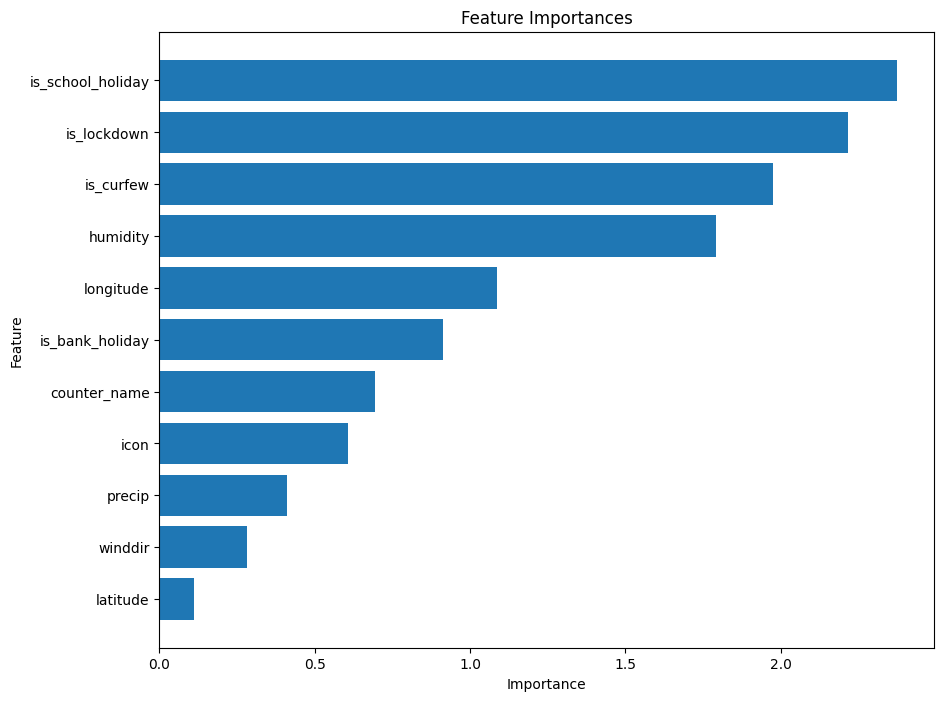

In [191]:
model = pipe.named_steps['catboostregressor']
feature_importances = model.get_feature_importance()
feature_names = processed_data.drop(columns=['date']).columns
importances = list(zip(feature_names, feature_importances))
importances.sort(key=lambda x: x[1], reverse=True)

# Splitting tuples into lists
names, values = zip(*importances)

# Creating the bar plot
plt.figure(figsize=(10, 8))
plt.barh(names, values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()